In [1]:
import sys
sys.path.append("../scripts/")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d
import mpol.constants as const
from mpol import coordinates
from mpol.gridding import DirtyImager
from scipy.spatial import cKDTree

# from scipy import signal

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json

plt.style.use("dark_background")

from utils import fits_to_tensor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
path = "/home/aadam/projects/rrg-lplevass/data/"

file = open(path + "score_models/ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
# score_model = ScoreModel(checkpoints_directory="/home/aadam/scratch/DeblendingGalaxies/models/ncsnpp_vp_probes_g_256_230824141338/")
# score_model = ScoreModel(checkpoints_directory="/home/aadam/scratch/DeblendingGalaxies/models/ncsnpp_vp_probes_z_256_230824141341/")
score_model = ScoreModel(checkpoints_directory="/home/aadam/scratch/DeblendingGalaxies/models/ncsnpp_vp_skirt_z_256_230813225243/")

FileNotFoundError: [Errno 2] No such file or directory: '/home/aadam/projects/rrg-lplevass/data/score_models/ncsnpp_ct_g_220912024942/model_hparams.json'

In [2]:
# Just take the first spectral window: 
data = np.load(path+"/HTLup_continuum_full.npz")

u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]


idx_inf= vis_per_spw[:-3].sum()
idx_sup = vis_per_spw[:-2].sum()
u = u[idx_inf:idx_sup]
v = v[idx_inf:idx_sup]
vis = vis[idx_inf:idx_sup]
weight = weight[idx_inf:idx_sup]


# Noé don't forget your minus signs
uu = np.concatenate([u, -u])
vv = np.concatenate([v, -v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, -vis.imag])
weight_ = np.concatenate([weight, weight])

In [3]:
def grid(pixel_scale, img_size): 
    """Given a pixel scale and a number of pixels in image space, grid the associated Fourier space

    Args:
        pixel_scale (float): Pixel resolution (in arcsec)
        img_size (float/int): Size of the image 

    Returns:
        
    """

    # Arcsec to radians: 
    dl = pixel_scale * const.arcsec
    dm = pixel_scale * const.arcsec

    du = 1 / (img_size * dl) * 1e-3 # klambda
    dv = 1 / (img_size * dm) * 1e-3 # klambda

    u_min = -img_size//2 * du 
    u_max = img_size//2 * du 

    v_min = -img_size//2 * dv
    v_max = img_size//2 * dv

    u_edges = np.linspace(u_min, u_max, img_size + 1)
    v_edges = np.linspace(v_min, v_max, img_size + 1)

    return u_edges, v_edges

pixel_scale = 0.0015
pad = 256 #768//2
img_size = 256
npix = img_size + 2 * pad
u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = npix)


def plot_uv_coverage(u, v, grid = False): 
    # Plot the uv coverage, if grid = True, plot the associated grid
    plt.scatter(u, v, s=0.5, rasterized=True, linewidths=0.0, c="r")

    if grid: 
        for x_coord in u_edges: 
            plt.axvline(x = x_coord, color = "gray", linestyle = "-", alpha = 0.5)

        for y_coord in v_edges:
            plt.axhline(y =y_coord, color = "gray", linestyle = "-", alpha = 0.5)
        

    plt.xlim([u.min(), u.max()])
    plt.ylim([v.min(), v.max()])
    plt.gca().set_aspect("equal")
    

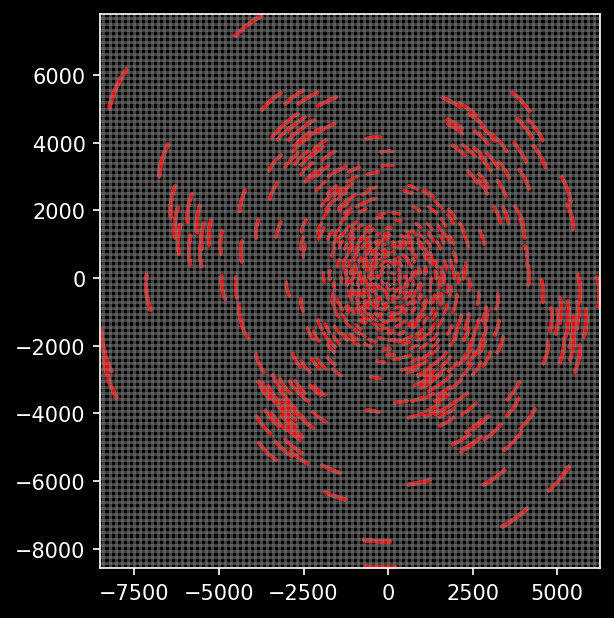

In [4]:
plot_uv_coverage(u, v, grid = True)

# Setup for the hack of binned statistics

## Define a bank of convolutional window and their Fourier transform

In [ ]:
# See http://www.gmrt.ncra.tifr.res.in/doc/WEBLF/LFRA/node90.html for a reference

def pillbox_window(delta_u, delta_v):
    return 1. 

def exponential_window(delta_u, delta_v, pixel_size=pixel_size, w=1):
    return np.exp(- np.abs(delta_u) / w / pixel_size) * np.exp(- np.abs(delta_v) / w / pixel_size)

def sinc_window(delta_u, delta_v, pixel_size=pixel_size, w=1):
    return np.exp(- np.abs(delta_u) / w / pixel_size) * np.exp(- np.abs(delta_v) / w / pixel_size)

## Misha's hack setup

In [5]:
# Misha's hack
# uv = np.stack([u, v], axis=1)
y_re = list(zip(vis_re, weight_, uu, vv))
y_imag = list(zip(vis_imag, weight_, uu, vv))
data_real = np.empty(len(y_re), dtype = object)
data_real[:] = y_re
data_imag = np.empty(len(y_imag), dtype = object)
data_imag[:] = y_imag

u_center = (u_edges[:-1] + u_edges[1:])/2
v_center = (v_edges[:-1] + v_edges[1:])/2
pixel_size = u_edges[1] - u_edges[0]
u_grid, v_grid = np.meshgrid(u_center, v_center, indexing="xy")

u_grid = u_grid.ravel()
v_grid = v_grid.ravel()
# Flatten the u_grid and v_grid and stack them to create 2D array
uv_grid = np.vstack((u_grid.ravel(), v_grid.ravel())).T

# Create a KDTree object
kdtree = cKDTree(uv_grid)


In [32]:

# def image_space_exponential_window(pixel_size=pixel_size, w=1):
    # return 

def nearest_uv(u, v):
    # Query the KDTree to find the index of the nearest point
    dist, index = kdtree.query([np.mean(u), np.mean(v)])
    # Get the u, v coordinates of the nearest point
    nearest_u, nearest_v = uv_grid[index]
    return nearest_u, nearest_v

def binned_mean(y):
    y = np.stack(y)
    values = y[:, 0]
    w = y[:, 1]
    u = y[:, 2]
    v = y[:, 3]
    
    nearest_u, nearest_v = nearest_uv(u, v)
    delta_u = nearest_u - u
    delta_v = nearest_v - v
    
    # Convolutional window function 
    conv_window =  exponential_window(delta_u, delta_v)

    return np.average(values * conv_window, weights = w)


# Not weighting the STD by the window function is risky, since window function change vis values
def binned_std(y):
    y = np.stack(y)
    values = y[:, 0]
    w = y[:, 1]
    return np.sqrt(np.cov(values, aweights=w)) #have to use cov since std doesn't accept weights :(

In [38]:
bin_x = u_edges
bin_y = v_edges

# def process_binstat(data, weight):
#     y = list(zip(data, weight))
#     out = np.empty(len(data), dtype = object)
#     out[:] = y
#     return out

# data_real = process_binstat(vis_re, weight_)
# data_imag = process_binstat(vis_imag, weight_)

# def binned_mean(y):
#     y = np.stack(y)
#     values = y[:, 0]
#     w = y[:, 1]
#     return np.average(values, weights = w)

# def binned_std(y):
#     y = np.stack(y)
#     values = y[:, 0]
#     w = y[:, 1]
#     return np.sqrt(np.cov(values, aweights=w)) #have to use cov since std doesn't accept weights :(

vis_bin_re, _, _, _ = binned_statistic_2d(vv, uu, values = data_real, bins = (bin_y, bin_x), statistic = binned_mean)
vis_bin_img, _, _, _ = binned_statistic_2d(vv, uu, values = data_imag, bins = (bin_y, bin_x), statistic = binned_mean)
std_bin_re, _, _, _ = binned_statistic_2d(vv, uu, values = data_real, bins = (bin_y, bin_x), statistic = binned_std)
std_bin_img, _, _, _ = binned_statistic_2d(vv, uu, values = data_imag, bins = (bin_y, bin_x), statistic = binned_std)
counts, _, _, _ = binned_statistic_2d(vv, uu, values = weight_, bins = (bin_y, bin_x), statistic = "count")

/tmp/ipykernel_232066/1201436190.py:47: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.sqrt(np.cov(values, aweights=w)) #have to use cov since std doesn't accept weights :(
/home/aadam/environments/milex/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/aadam/environments/milex/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_232066/1201436190.py:47: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.sqrt(np.cov(values, aweights=w)) #have to use cov since std doesn't accept weights :(
/home/aadam/environments/milex/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/aadam/environments/milex/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: Run

In [39]:
# From object type to float
vis_bin_re = vis_bin_re.astype(float)
vis_bin_img = vis_bin_img.astype(float)
std_bin_re = std_bin_re.astype(float) 
std_bin_img = std_bin_img.astype(float)
counts = counts.astype(float)

# i.e. The sampling function where there is data in the uv plane
mask = counts>0 

# binned_stat outputs nans, we put everything to zero instead
vis_bin_re[~mask] = 0.
vis_bin_img[~mask] = 0.
std_bin_re[~mask] = 0.
std_bin_img[~mask] = 0.
counts[~mask] = 0.

std_bin_re /= (counts + 1)**0.5
std_bin_img /= (counts + 1)**0.5


# To compute the dirty image
vis_grid = np.fft.fftshift(vis_bin_re + 1j * vis_bin_img)

# For the inference, fftshift + flatten everything for the fft
vis_gridded_re = np.fft.fftshift(vis_bin_re).flatten()
vis_gridded_img = np.fft.fftshift(vis_bin_img).flatten()
std_gridded_re = np.fft.fftshift(std_bin_re).flatten()
std_gridded_img = np.fft.fftshift(std_bin_re).flatten()
S_grid = np.fft.fftshift(mask).flatten()


In [40]:
def plot_dirty_image(vis_gridded): 
    dirty_image = npix ** 2 * np.fft.fftshift(np.fft.ifft2(vis_gridded))[::-1].real
    im = plt.imshow(dirty_image, origin = "lower", cmap = "magma")  # flip needed due to CASA's convention  
    plt.colorbar(im, fraction = 0.046, label = "Jy/beam ?")

In [ ]:
dirty_image = plot_dirty_image(vis_grid)

In [35]:
# Numpy to torch: 
S_cat = np.concatenate([S_grid, S_grid])
vis_gridded = np.concatenate([vis_gridded_re, vis_gridded_img])
std_gridded = np.concatenate([std_gridded_re, std_gridded_img])

S = torch.tensor(S_cat).to(device)
y = torch.tensor(vis_gridded, device = S.device)[S].to(device) * npix
sigma_y = torch.tensor(std_gridded, device = S.device)[S].to(device) * npix

In [36]:
print(f"Max, mean, min y: {y.max():.2g}, {y.min():.2g}, {y.mean():.2g}")
print(f"Max, mean, min sigma_y: {sigma_y.max():.2g}, {sigma_y.min():.2g}, {sigma_y.mean():.2g}")

Max, mean, min y: 9.9, -59, -29
Max, mean, min sigma_y: 5.4e+05, 5.4e+05, 5.4e+05


In [37]:
def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

C = 0.5 # VE prior
B = 0.5 # VE
C = 1 # VP prior
# C = 0.1 # VP guess at a link
B = 0 # VP
def link_function(x):
    return C * x + B

def flip(x): 
    return x[:, ::-1]

In [14]:
def noise_padding(x, pad, sigma):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

In [15]:
def generate_pb(diameter = 12, freq = 432058061289.4426, shape = (500, 500), deltal = 0.004):
    #Some credit to ChatGPT....I got lazy lol
    wavelength = c / freq
    fwhm = 1.02 * wavelength / diameter * (180/torch.pi) * (3600)
    half_fov = deltal * shape[0] / 2
    #Grid for PB
    x = np.linspace(-half_fov, half_fov, shape[0])
    y = np.linspace(-half_fov, half_fov, shape[1])
    x, y = np.meshgrid(x, y)
    #Gaussian PB parameters
    mean = [0, 0]  # Mean (center) of the Gaussian
    std = fwhm / (2*np.sqrt(2*np.log(2)))
    covariance_matrix = np.array([[std, 0], [0, std]])  # Covariance matrix
    # 2-D Gaussian PB
    x_y = np.column_stack([x.ravel(), y.ravel()])
    pb = (
        1 / (2 * np.pi * np.sqrt(np.linalg.det(covariance_matrix)))
    ) * np.exp(-0.5 * np.sum(np.dot(x_y - mean, np.linalg.inv(covariance_matrix)) * (x_y - mean), axis=1))
    # Reshape the PDF values to match the shape of the grid
    pb = pb.reshape(x.shape)
    return pb, fwhm

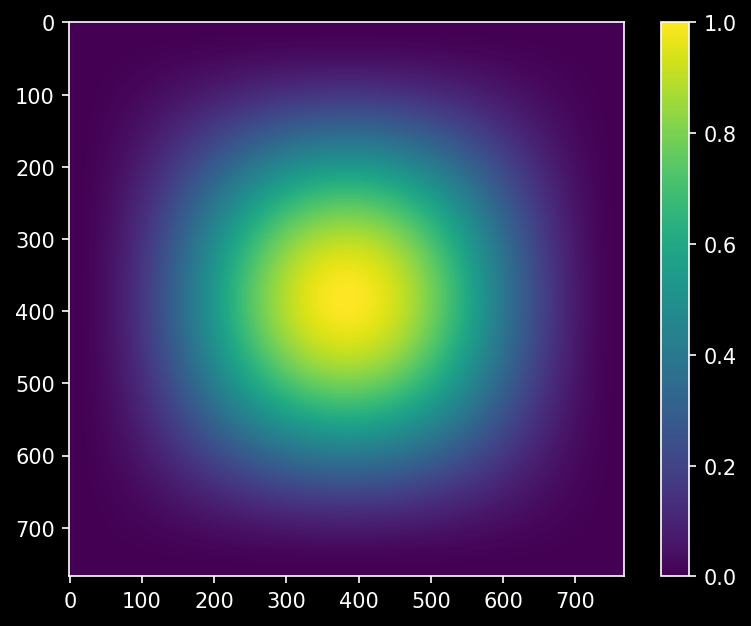

In [16]:
# w = torch.hamming_window(npix)
w = torch.hann_window(npix)
w = torch.outer(w, w)
w = w.to(device)
plt.imshow(w.cpu())
plt.colorbar()

In [17]:
#sigma_y = 1e8 * torch.ones(len(y)).to(device)
#beta = 0
# def sigma(t): 
    # return sigma_min * (sigma_max/sigma_min) ** t

def sigma(t):
    return score_model.sde.sigma(t)

def mu(t):
    return score_model.sde.marginal_prob_scalars(t)[0]

def model(x, t):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = noise_padding(x, pad=pad, sigma=sigma(t))
    x = link_function(x) # map from model unit space to real unit space
    # x = w * x
    vis_full = ft(torch.fft.fftshift(x)).flatten() 
    vis_sampled = vis_full
    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
    return vis_sampled[S]


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x, t)
    var = sigma(t) **2 / 2 * C**2 + mu(t)**2 * sigma_y**2
    log_prob = -0.5 * torch.sum((mu(t) * y - y_hat)**2 / var)
    return log_prob


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(y, x, t, sigma_y): 
    x = x.flatten(start_dim = 1)
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)), randomness = "different")(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(y, x, t, sigma_y) 

k = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(y, k, t, sigma_y)**2))**0.5)
print(score_posterior(k, t))

tensor(nan, device='cuda:0')
tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<AddBackward0>)


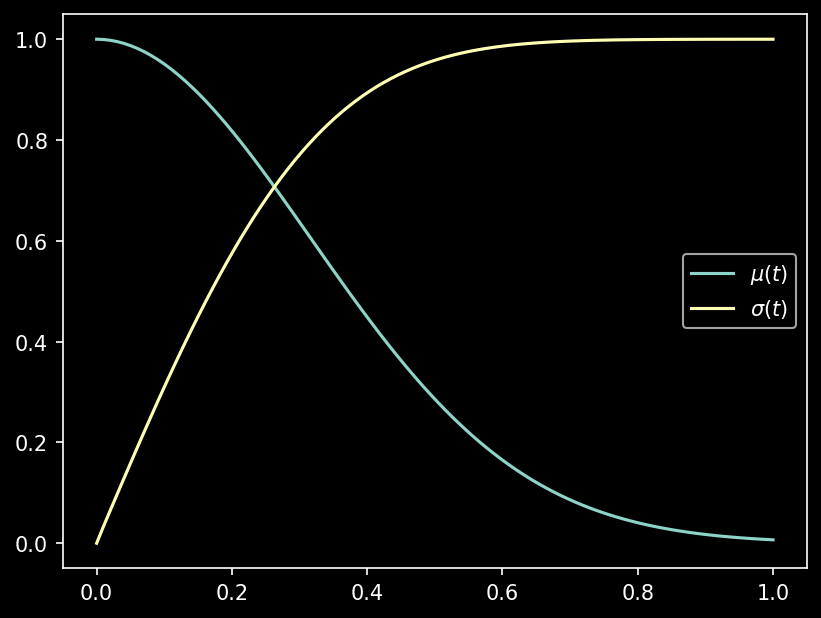

In [18]:
t = torch.linspace(0, 1, 100)

plt.plot(t, mu(t), label=r"$\mu(t)$")
plt.plot(t, sigma(t), label=r"$\sigma(t)$")
plt.legend()

In [19]:
# def g(t): 
    # return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
    
def g(t, x):
    return score_model.sde.diffusion(t, x)

def drift_fn(t, x):
    return score_model.sde.drift(t, x)
    

def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return torch.flip(link_function(x_mean).reshape(num_samples, img_size, img_size), dims = (2,))

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device) * sigma(t)
    dt = -1/num_steps
    
    chain = []
    with torch.no_grad(): 
        for _ in (pbar := tqdm(range(num_steps - 1))): 
            pbar.set_description(f"t = {t[0].item():.2f} | scale ~ {x.std():.2e} | sigma(t) = {sigma(t)[0].item():.2e} | mu(t) = {mu(t)[0].item():.2e}")
            t += dt
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            
            chain.append(x.cpu().numpy())

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return torch.flip(link_function(x_mean).reshape(num_samples, img_size, img_size), dims = (2,)), chain

pred = 500
corr = 100
snr = 1e-2
num_samples = 1
samples, chain = euler_sampler(num_samples = num_samples, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 1, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

t = 1.00 | scale ~ 9.96e-01 | sigma(t) = 1.00e+00 | mu(t) = 6.72e-03:   0%|          | 0/499 [00:00<?, ?it/s]

Nans appearing


In [20]:
# plt.plot([_x.std() for _x in chain])

In [68]:
# log_likelihood(y, torch.tensor(chain[0]).to(device), t=torch.ones(1).to(device), sigma_y=sigma_y)

IndexError: list index out of range

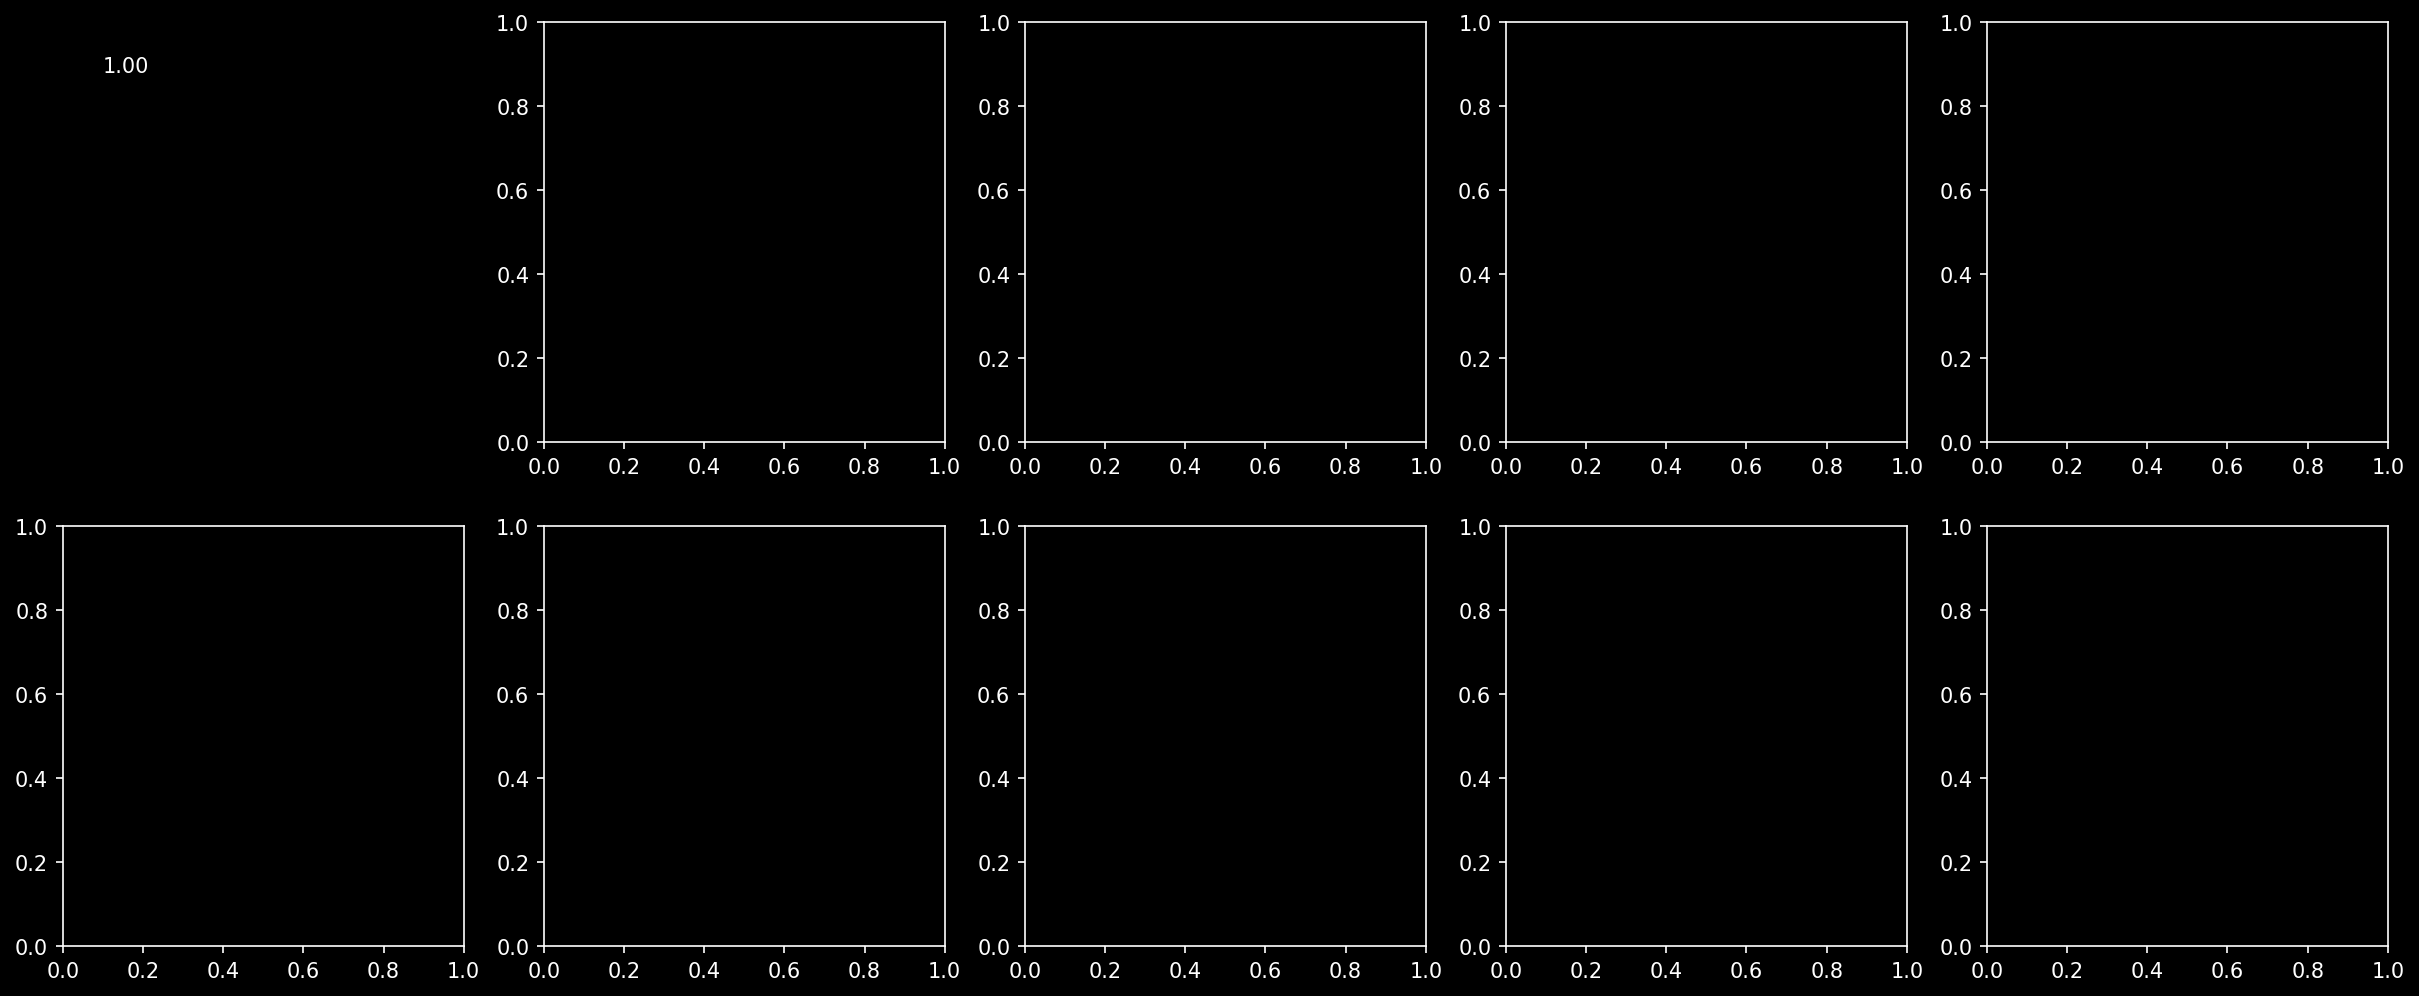

In [69]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(256, 256), cmap="magma")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [ ]:
norm = True
save = False
n_images = samples.shape[0]
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((link_function(samples[k])).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"../../images/HTLup_pad{img_size}norm.jpeg"
        norm = ImageNormalize(samples.cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    else: 
        save_path = f"../../images/HTLup_pad{img_size}nonorm.jpeg"
        norm = None
    plt.imshow(samples[0].cpu(), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

In [363]:
# residuals = (y - model(samples))/sigma_y

In [27]:
sigma_y.mean()

tensor(3.4176e-07, dtype=torch.float64)

In [83]:
(std_gridded_re/(count+1)).mean()

3.2939683515150124e-07

In [84]:
vis_gridded_re.mean()

2.063231375540872e-05

In [7]:
def flip(x): 
    return x[:, ::-1]

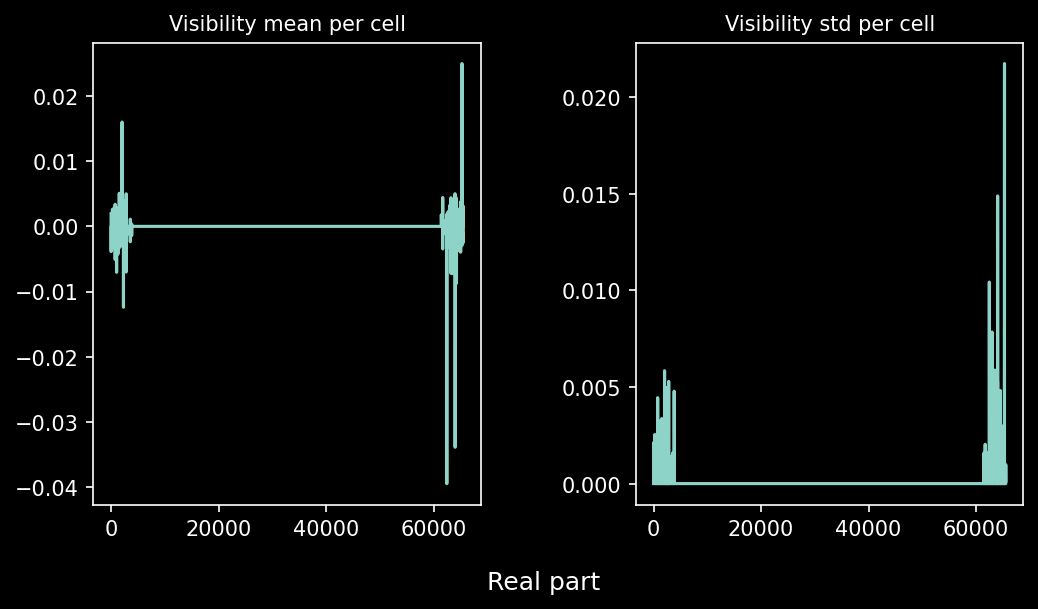

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (4*2, 4))
axs[0].plot(vis_gridded_img)
axs[0].set_title("Visibility mean per cell", size = 10)

axs[1].plot(std_gridded_img)
axs[1].set_title("Visibility std per cell", size = 10)

fig.suptitle("Imaginary part", y = 0.001)
plt.subplots_adjust(wspace = 0.4)

In [66]:
S_count = count>0.0
S_std = std_gridded_re.astype(bool)

In [67]:
S_std.min()

False

In [68]:
(S_count == S_std)

C:\Users\noedi\AppData\Local\Temp\ipykernel_12852\863845559.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (S_count == S_std)


False

In [75]:
S_count[0, 0]

False

In [76]:
np.where(S_count != np.fft.fftshift(S_std.reshape(img_size, img_size)))

(array([], dtype=int64), array([], dtype=int64))

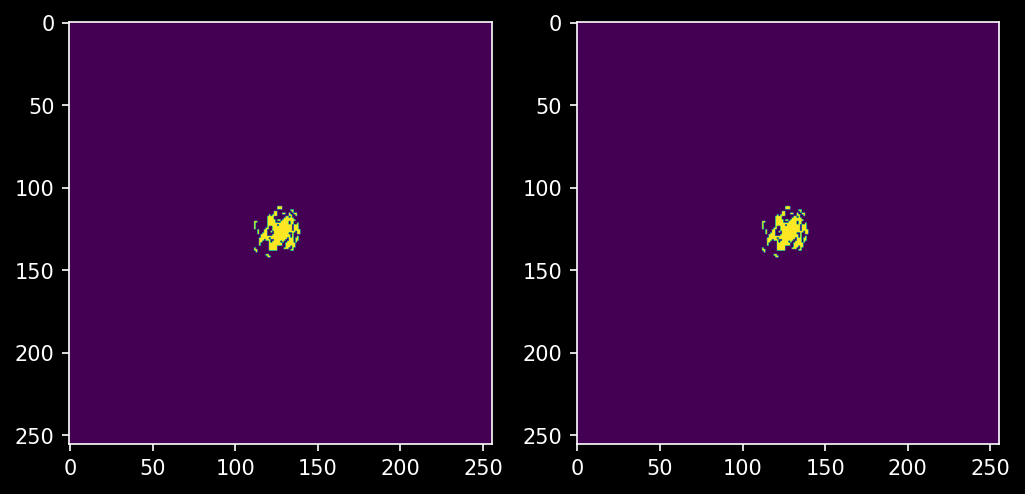

In [69]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

axs[0].imshow(S_count.reshape(img_size, img_size))
axs[1].imshow(np.fft.fftshift(S_std.reshape(img_size, img_size)))

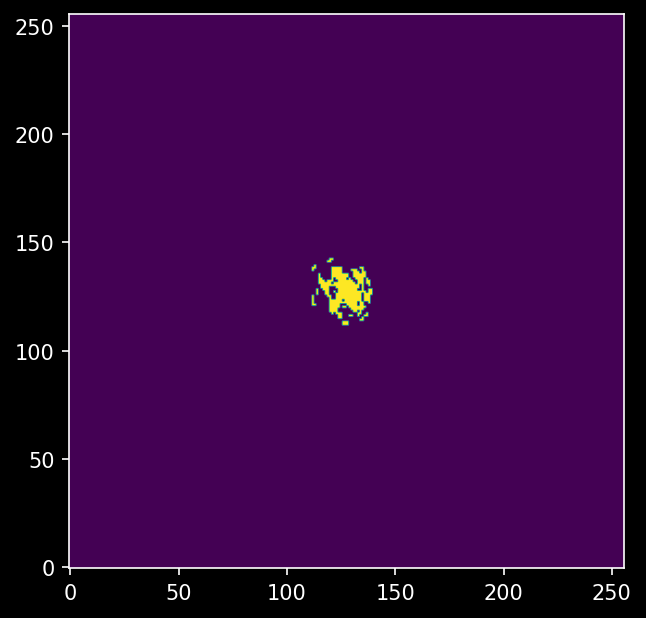

In [34]:
plt.imshow(np.fft.fftshift(S_grid.reshape(img_size, img_size)), origin = "lower")

In [23]:
vis_grid.real.max()

0.061462025318957836

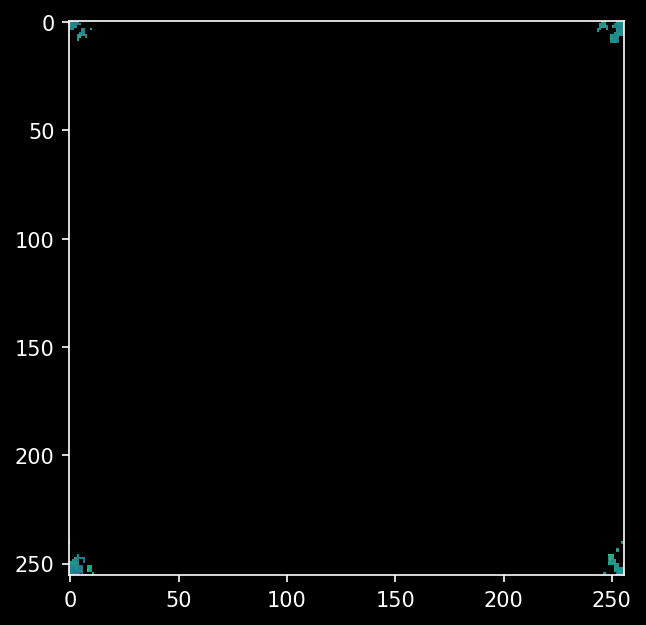

In [28]:
plt.imshow(std_gridded_re.reshape(img_size, img_size))

In [41]:
vis_grid.mean()

(2.063231375540872e-05-1.4509849062735517e-06j)

In [45]:
(std_gridded_re/ (count.flatten() + 1)).mean()

0.00035093002704310967

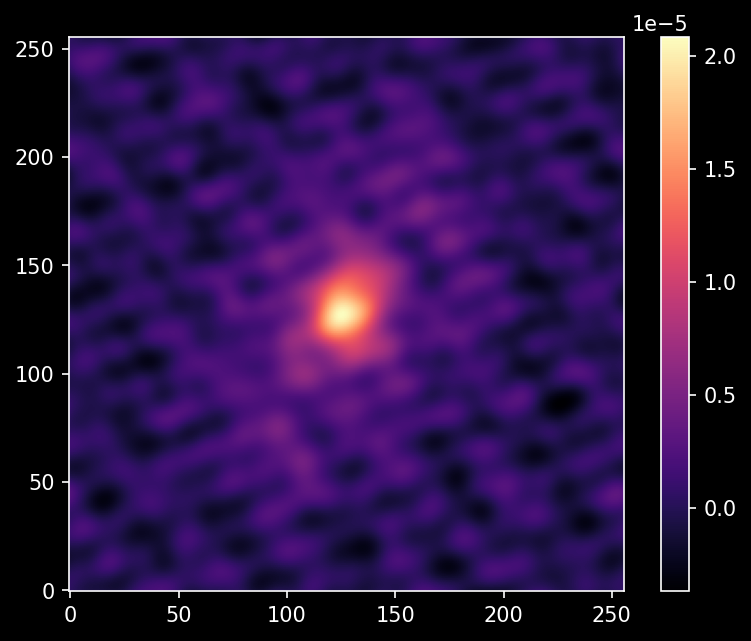

In [36]:
dirty_image = flip(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(vis_grid))))
plt.imshow(dirty_image.real, cmap = "magma", origin = "lower")
plt.colorbar()